In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.linalg import eigh
from scipy.linalg import null_space
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import curve_fit
from scipy.integrate import simps 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.widgets import Slider

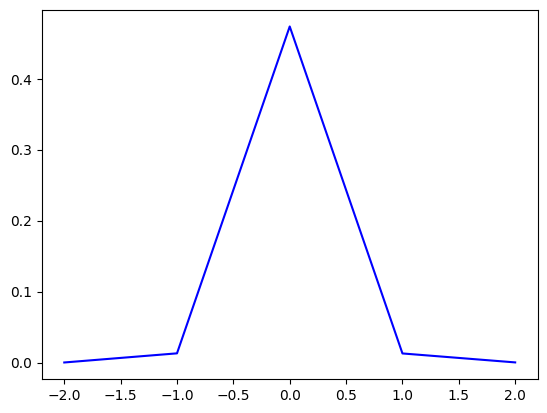

In [2]:
def open_txt(inputstring):
    with open(inputstring, 'r') as f:
        contents = f.read()
    cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
    array = np.array([float(val) for val in cleaned])
    x = array[::2]
    y = array[1::2]
    return x, y

x1, y1 = open_txt('Regime1.txt')
x2, y2 = open_txt('Regime2.txt')
x3, y3 = open_txt('Regime3.txt')

fig = plt.figure()
plt.plot(x1[510:515], y1[510:515], color = 'blue')
plt.xlabel("")
plt.ylabel("")
plt.show()

In [3]:
w_eff1 = 2*np.pi*3205
w_eff2 = 2*np.pi*3878
w_eff3 = 2*np.pi*5008

In [4]:
def calculate_eta(w_eff, tau_c):
    
    def J(w, tau_c):
        return (tau_c)/(1 + (w*tau_c)**2)

    pulselength = 38e-6
    delay = 40e-6
    omega = (2*np.pi) / (pulselength + delay)

    eta = 0
    for k in range(510,515):
        eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)
    
    return eta

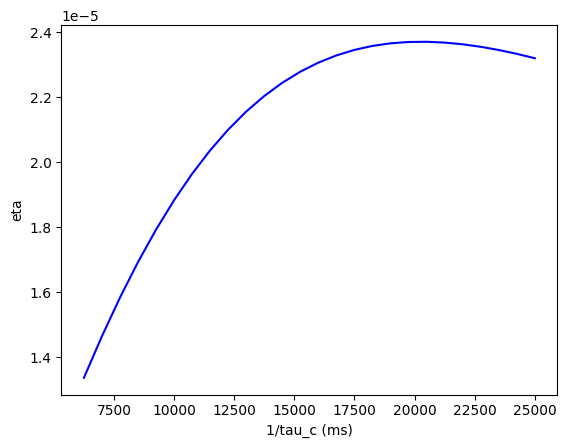

In [5]:
tau_c = 1/(np.linspace(1/4e-5, 1/1.6e-4, 26))
eta = np.zeros(26)
for i in range(26):
    eta[i] = calculate_eta(w_eff1, tau_c[i])
    
fig = plt.figure()
plt.plot((1/tau_c), eta, color = 'blue')
# plt.gca().invert_xaxis() 
plt.xlabel("1/tau_c (ms)")
plt.ylabel("eta")
plt.show()

C:\Users\Suber\AppData\Local\Temp\ipykernel_43852\1725140747.py:8: RuntimeWarning: overflow encountered in exp
  R1 = A1 + (A2)/(np.exp(delta/k_b*Temp) - 1) + A3 * Temp**5


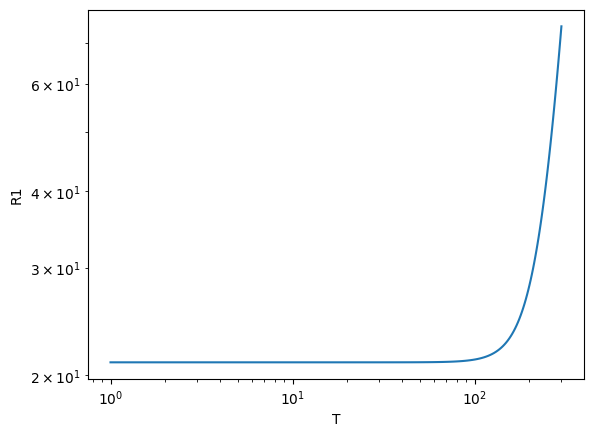

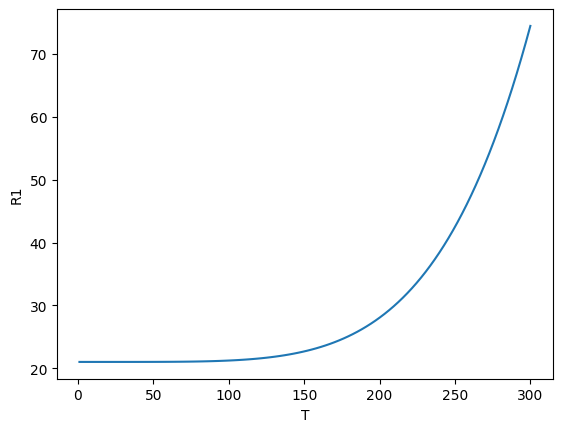

correlation times [0.04761905 0.04761905 0.04761905 0.04761904 0.04761903 0.04761899
 0.04761892 0.04761878 0.04761854 0.04761816 0.04761757 0.04761671
 0.04761547 0.04761377 0.04761147 0.04760843 0.04760449 0.04759945
 0.04759311 0.04758523 0.04757554 0.04756375 0.04754953 0.04753254
 0.04751239 0.04748866 0.0474609  0.04742863 0.04739133 0.04734845
 0.04729939 0.04724355 0.04718027 0.04710885 0.0470286  0.04693875
 0.04683854 0.04672717 0.04660382 0.04646768 0.04631788 0.04615359
 0.04597394 0.04577811 0.04556524 0.04533453 0.0450852  0.04481649
 0.0445277  0.04421819 0.04388736 0.04353471 0.04315979 0.04276228
 0.04234193 0.04189861 0.04143228 0.04094306 0.04043117 0.03989695
 0.03934089 0.03876359 0.03816579 0.03754835 0.03691226 0.03625862
 0.03558863 0.03490359 0.03420488 0.03349398 0.03277239 0.0320417
 0.0313035  0.03055942 0.02981109 0.02906013 0.02830815 0.0275567
 0.02680732 0.02606148 0.02532056 0.02458591 0.02385878 0.02314033
 0.02243164 0.0217337  0.02104741 0.02037355 0

In [8]:
k_b = 1.38e-23
A1 = 21
A2 = 2.1e3
A3 = 2.2e-11 
delta = 1.17e-20 #J

Temp = np.linspace(1,300,100)
R1 = A1 + (A2)/(np.exp(delta/k_b*Temp) - 1) + A3 * Temp**5
tau_c = 1/R1
    
fig = plt.figure()
plt.loglog(Temp, R1)
plt.xlabel("T")
plt.ylabel("R1")
plt.show()

fig = plt.figure()
plt.plot(Temp, R1)
plt.xlabel("T")
plt.ylabel("R1")
plt.show()

print('correlation times', tau_c)

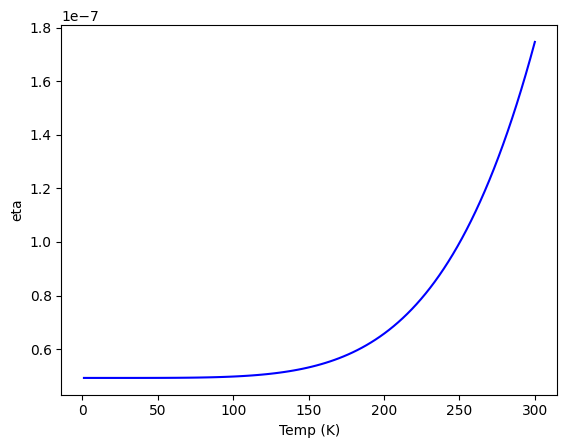

In [9]:
eta = np.zeros(100)
for i in range(100):
    eta[i] = calculate_eta(w_eff1, tau_c[i])
    
fig = plt.figure()
plt.plot(Temp, eta, color = 'blue')
# plt.gca().invert_xaxis() 
plt.xlabel("Temp (K)")
plt.ylabel("eta")
plt.show()

In [39]:
#Run different lattice configurations simultaneously using different CPU cores
#Then average over different iterations, fit, and extract rates
#Repeat all of this for different values of tau_p and tau_d

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def open_txt(inputstring):
        with open(inputstring, 'r') as f:
            contents = f.read()
        cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
        array = np.array([float(val) for val in cleaned])
        x = array[::2]
        y = array[1::2]
        return x, y

    x1, y1 = open_txt('Regime1.txt')
    x2, y2 = open_txt('Regime2.txt')
    x3, y3 = open_txt('Regime3.txt')
    
    w_eff1 = 2*np.pi*3205
    w_eff2 = 2*np.pi*3878
    w_eff3 = 2*np.pi*5008
    
    def calculate_eta(w_eff, tau_c):

        def J(w, tau_c):
            return (tau_c)/(1 + (w*tau_c)**2)

        pulselength = 38e-6
        delay = 40e-6
        omega = (2*np.pi) / (pulselength + delay)

        eta = 0
        for k in range(510,515):
            eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)

        return eta

    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)
        
        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
#                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)
            
                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_c, tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0, 300, 100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(size, carbon_pts, e_pts, tau_p*calculate_eta(w_eff1, tau_c), tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


import time

def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate    
    
    
N = 10 #Number of temp. values

iterations = 10
tau_p = 2.5e2*1.45e-3*np.ones(N)
tau_d = 2.5e-5*np.ones(N)
# tau_c = 1/(np.linspace(1/4e-5, 1/1.6e-4, N))

k_b = 1.38e-23
A1 = 21
A2 = 2.1e3
A3 = 2.2e-11 
delta = 1.17e-20 #J

Temp = np.linspace(300,1,N)
R1 = A1 + (A2)/(np.exp(delta/k_b*Temp) - 1) + A3 * Temp**5
tau_c = 1/R1

stretched_rate = np.zeros((N,iterations))
mono_rate = np.zeros((N,iterations))

stretched_avg = np.zeros(N)
mono_avg = np.zeros(N)

for i in range(N):
    print(f"Running tau_c value = {i}")
    start_time = time.time()
    
    inputs = [(tau_c[i], tau_p[i], tau_d[i])] * iterations 
    pool = Pool()
    pool.restart()
    results = pool.map(run_simulation, inputs)
#     pool.close()
#     pool.join()

    T = np.linspace(0, 300, 100)
    P = np.array(results)
    
    for j in range(iterations):
        stretched_rate[i,j], mono_rate[i,j] = fit_product(P[j,:],T)
        
    P_avg = (np.sum(np.array(results), axis=0))/iterations
    
    stretched_avg[i], mono_avg[i] = fit_product(P_avg,T)
    
    print(f"Tau_c value {i} completed in {time.time() - start_time:.2f} seconds")

C:\Users\Suber\AppData\Local\Temp\ipykernel_43852\666994526.py:241: RuntimeWarning: overflow encountered in exp
  R1 = A1 + (A2)/(np.exp(delta/k_b*Temp) - 1) + A3 * Temp**5


Running tau_c value = 0
Tau_c value 0 completed in 622.54 seconds
Running tau_c value = 1
Tau_c value 1 completed in 542.36 seconds
Running tau_c value = 2
Tau_c value 2 completed in 570.59 seconds
Running tau_c value = 3
Tau_c value 3 completed in 574.34 seconds
Running tau_c value = 4
Tau_c value 4 completed in 535.00 seconds
Running tau_c value = 5
Tau_c value 5 completed in 538.08 seconds
Running tau_c value = 6
Tau_c value 6 completed in 571.76 seconds
Running tau_c value = 7
Tau_c value 7 completed in 613.58 seconds
Running tau_c value = 8
Tau_c value 8 completed in 591.07 seconds
Running tau_c value = 9
Tau_c value 9 completed in 546.08 seconds
Running tau_c value = 10
Tau_c value 10 completed in 507.10 seconds
Running tau_c value = 11
Tau_c value 11 completed in 573.43 seconds
Running tau_c value = 12
Tau_c value 12 completed in 615.83 seconds
Running tau_c value = 13
Tau_c value 13 completed in 516.67 seconds
Running tau_c value = 14
Tau_c value 14 completed in 575.07 seconds


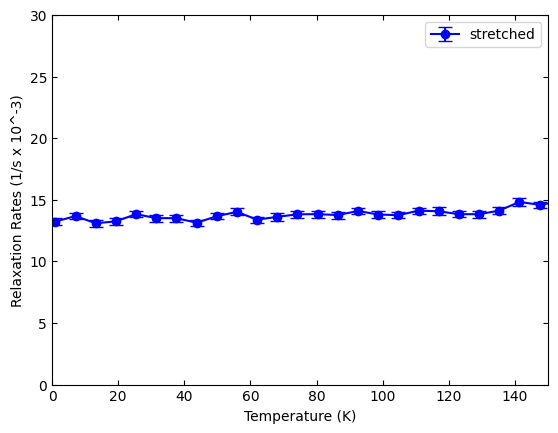

In [58]:
stretched_mean = np.mean(stretched_rate, axis=1)
mono_mean = np.mean(mono_rate, axis=1)

stretched_error = (np.sqrt(np.var(stretched_rate, axis=1)/iterations))
mono_error = (np.sqrt(np.var(mono_rate, axis=1)/iterations))

fig = plt.figure()
plt.errorbar(Temp, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
# plt.errorbar((1/tau_c), mono_avg, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
plt.xlabel("Temperature (K)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlim(0,150)
plt.ylim(0,30)
plt.legend()
plt.show()

# filename = f"Regime1_500Itr_PBC_v1.npz"
# np.savez(filename, corr_time = tau_c, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\TempMonteCarlo_zoomed_PBC.eps", format='eps', dpi=300)

In [26]:
#Run different lattice configurations simultaneously using different CPU cores
#Then average over different iterations, fit, and extract rates
#Repeat all of this for different values of tau_p and tau_d

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def open_txt(inputstring):
        with open(inputstring, 'r') as f:
            contents = f.read()
        cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
        array = np.array([float(val) for val in cleaned])
        x = array[::2]
        y = array[1::2]
        return x, y

    x1, y1 = open_txt('Regime1.txt')
    x2, y2 = open_txt('Regime2.txt')
    x3, y3 = open_txt('Regime3.txt')
    
    w_eff1 = 2*np.pi*3205
    w_eff2 = 2*np.pi*3878
    w_eff3 = 2*np.pi*5008
    
    def calculate_eta(w_eff, tau_c):

        def J(w, tau_c):
            return (tau_c)/(1 + (w*tau_c)**2)

        pulselength = 38e-6
        delay = 40e-6
        omega = (2*np.pi) / (pulselength + delay)

        eta = 0
        for k in range(510,515):
            eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)

        return eta

    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_c, tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,500,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p*calculate_eta(w_eff1, tau_c), tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P

import time
def product_exp(x, a, b):
    return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

N = 50 #Number of tau_p, tau_d values

T = np.linspace(0,500,100)
stretched_rate = np.zeros(N)
monoexp_rate = np.zeros(N)
rmse = np.zeros(N)

iterations = 100 #Monte Carlo runs

# tau_c = 1/(np.linspace(1/5.7e-5, 1/3.3e-4, 51))
# tau_c = 3.3e-4
k_b = 1.38e-23
A1 = 15
A2 = 2.1e3
A3 = 2.2e-11 
delta = 1.17e-20 #J

Temp = np.linspace(300,1,50)
R1 = A1 + (A2)/(np.exp(delta/k_b*Temp) - 1) + A3 * Temp**5
tau_c = 1/R1

tau_p = 20*np.ones(N)
tau_d = 0.8e-2*np.ones(N)
# tau_p = 0.13*np.ones(N)
# tau_d = 1e-2*np.linspace(1.6, 0.8, N)

for i in range(N):
    start_time = time.time()
    inputs = [(tau_c[i], tau_p[i], tau_d[i])] * iterations

    pool = Pool()
    results = pool.map(run_simulation, inputs)

    end_time = time.time()
    print(end_time-start_time)

    P_avg = (np.sum(np.array(results), axis=0))/iterations

    # Fit the data
    popt, pcov = curve_fit(product_exp, T, P_avg, bounds=([0, 0], [1, 1]))

    y_fit = product_exp(T, *popt)
    residuals = P_avg - y_fit
    rmse[i] = np.sqrt(np.mean(residuals**2))

    stretched_rate[i] = popt[0]*1e3
    monoexp_rate[i] = popt[1]*1e3
    
print('rmse errors: ', rmse)

C:\Users\Suber\AppData\Local\Temp\ipykernel_62132\936483444.py:223: RuntimeWarning: overflow encountered in exp
  R1 = A1 + (A2)/(np.exp(delta/k_b*Temp) - 1) + A3 * Temp**5


74.79503798484802
70.0313982963562
76.32476091384888
71.10797595977783
69.39631986618042
67.08531355857849
72.37992596626282
67.18520712852478
66.92148447036743
82.74151849746704
76.9585165977478
70.11680340766907
77.46519684791565
75.78391885757446
68.49969959259033
80.32200479507446
64.76357769966125
65.69140291213989
74.14047527313232
62.984132528305054
72.00497627258301
62.84707832336426
72.11922883987427
56.788649559020996
64.81582283973694
62.821736097335815
62.79564189910889
65.55944871902466
54.99473524093628
67.26590538024902
62.70635938644409
66.28270149230957
59.29940390586853
63.41393280029297
60.71115732192993
68.21207046508789
61.57871222496033
64.17314910888672
69.14999771118164
66.530686378479
61.544153928756714
66.51686334609985
69.76826739311218
74.4540343284607
67.83694553375244
65.73766160011292
59.49396228790283
60.48635458946228
65.12498712539673
59.120779037475586
rmse errors:  [0.00064272 0.00068444 0.00109114 0.000625   0.00115252 0.00134948
 0.00112961 0.00107

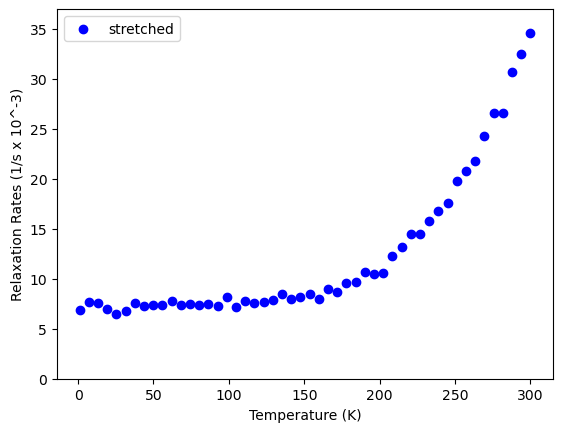

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [36]:
Temp = np.linspace(300,1,50)
fig = plt.figure()
plt.scatter(Temp, stretched_rate, color = 'blue', label = 'stretched')
# plt.scatter(Temp, monoexp_rate, color = 'red', label = 'monoexp')
# plt.gca().invert_xaxis() 
plt.xlabel("Temperature (K)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.ylim([0,37])
plt.legend()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\TempMonteCarlo.eps", format='eps', dpi=300)

In [23]:
#Run different lattice configurations simultaneously using different CPU cores
#Then average over different iterations, fit, and extract rates
#Repeat all of this for different values of tau_p and tau_d

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def open_txt(inputstring):
        with open(inputstring, 'r') as f:
            contents = f.read()
        cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
        array = np.array([float(val) for val in cleaned])
        x = array[::2]
        y = array[1::2]
        return x, y

    x1, y1 = open_txt('Regime1.txt')
    x2, y2 = open_txt('Regime2.txt')
    x3, y3 = open_txt('Regime3.txt')
    
    w_eff1 = 2*np.pi*3205
    w_eff2 = 2*np.pi*3878
    w_eff3 = 2*np.pi*5008
    
    def calculate_eta(w_eff, tau_c):

        def J(w, tau_c):
            return (tau_c)/(1 + (w*tau_c)**2)

        pulselength = 38e-6
        delay = 40e-6
        omega = (2*np.pi) / (pulselength + delay)

        eta = 0
        for k in range(510,515):
            eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)

        return eta

    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M


    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_c, tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,300,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p*calculate_eta(w_eff1, tau_c), tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


import time

def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate    
    
    
N = 10 #Number of tau_c values

iterations = 16
tau_p = 0.105*np.ones(N)
tau_d = 1e-2*np.linspace(1.5, 0.7, N)
# tau_c = 1/(np.linspace(1/4e-5, 1/1.6e-4, N))

k_b = 1.38e-23
A1 = 5000
A2 = 2.1e3
A3 = 2.2e-11 
delta = 1.17e-20 #J

Temp = np.linspace(1,300,N)
R1 = A1 + (A2)/(np.exp(delta/k_b*Temp) - 1) + A3 * Temp**5
tau_c = 1/R1

stretched_rate = np.zeros((N,iterations))
mono_rate = np.zeros((N,iterations))

stretched_avg = np.zeros(N)
mono_avg = np.zeros(N)

for i in range(N):
    print(f"Running tau_c value = {i}")
    start_time = time.time()
    
    inputs = [(tau_c[i], tau_p[i], tau_d[i])] * iterations 
    pool = Pool()
    pool.restart()
    results = pool.map(run_simulation, inputs)
    pool.close()
    pool.join()

    T = np.linspace(0,300,100)
    P = np.array(results)
    
    for j in range(iterations):
        stretched_rate[i,j], mono_rate[i,j] = fit_product(P[j,:],T)
        
    P_avg = (np.sum(np.array(results), axis=0))/iterations
    
    stretched_avg[i], mono_avg[i] = fit_product(P_avg,T)
    
    print(f"Tau_c value {i} completed in {time.time() - start_time:.2f} seconds")

C:\Users\Suber\AppData\Local\Temp\ipykernel_51340\1500096763.py:228: RuntimeWarning: overflow encountered in exp
  R1 = A1 + (A2)/(np.exp(delta/k_b*Temp) - 1) + A3 * Temp**5


Running tau_c value = 0
Tau_c value 0 completed in 8.58 seconds
Running tau_c value = 1
Tau_c value 1 completed in 7.73 seconds
Running tau_c value = 2
Tau_c value 2 completed in 7.80 seconds
Running tau_c value = 3
Tau_c value 3 completed in 7.93 seconds
Running tau_c value = 4
Tau_c value 4 completed in 7.82 seconds
Running tau_c value = 5
Tau_c value 5 completed in 7.78 seconds
Running tau_c value = 6
Tau_c value 6 completed in 7.92 seconds
Running tau_c value = 7
Tau_c value 7 completed in 7.75 seconds
Running tau_c value = 8
Tau_c value 8 completed in 7.71 seconds
Running tau_c value = 9
Tau_c value 9 completed in 8.03 seconds


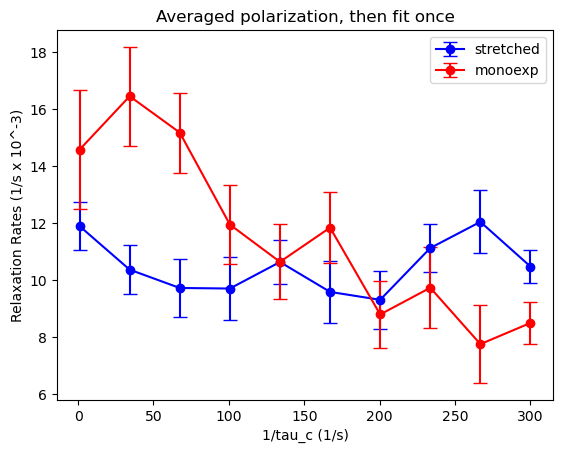

In [25]:
stretched_mean = np.mean(stretched_rate, axis=1)
mono_mean = np.mean(mono_rate, axis=1)

stretched_error = (np.sqrt(np.var(stretched_rate, axis=1)/iterations))
mono_error = (np.sqrt(np.var(mono_rate, axis=1)/iterations))

# fig = plt.figure()
# plt.errorbar((1/tau_c), stretched_mean, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
# plt.errorbar((1/tau_c), mono_mean, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
# plt.title("Fit all trajectories, then averaged rates")
# plt.xlabel("1/tau_c (1/s)")
# plt.ylabel("Relaxation Rates (1/s x 10^-3)")
# plt.legend()
# plt.show()

fig = plt.figure()
plt.errorbar(Temp, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(Temp, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
plt.xlabel("Temp (K)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

# filename = f"Regime1_500Itr_v2.npz"
# np.savez(filename, corr_time = tau_c, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)